# Amortized Inference for a NLME Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypesto import Problem, optimize, sample, visualize, profile, engine
from pypesto.objective import Objective, AggregatedObjective, NegLogParameterPriors
from scipy import stats

from inference.helper_functions import (create_mixed_effect_model_param_names,
                                        analyse_correlation_in_posterior,
                                        create_fixed_params)
from inference.inference_functions import run_population_optimization
from inference.ploting_routines import (plot_real_vs_synthetic,
                                        plot_real_and_estimated,
                                        plot_normal_distributions,
                                        visualize_pesto_result)

/Users/jonas.arruda/miniconda/envs/Amortized-NLME/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# specify which model to use
model_name = ['fröhlich-simple', 'fröhlich-detailed', 'fröhlich-sde', 'pharmacokinetic_model', 
              'dePillis'][-1]

# Load individual model

  Activating project at `~/PyCharm Projects/Amortized-NLME-Models/models/SimulatorDePillis`


using 2 layers of MultiConv1D, a bidirectional LSTM with 32 units and a dense layer with output dimension 18 as summary network
using a 6-layer cINN as inference network with 3 layers of design spline
Using de Pillis prior
prior mean: [  2.30258509  -4.60517019  -0.69314718 -11.51292546 -11.51292546
   2.30258509   4.00733319  -2.30258509  -2.30258509]
prior covariance diagonal: [5. 5. 5. 5. 5. 3. 3. 1. 1.]
Using the model dePillisModel


INFO:root:Performing 2 pilot runs with the dePillisModel model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 9)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 7, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-6layers-3coupling-spline-300epochs_normal/history_258.pkl.
INFO:root:Networks loaded from ../networks/amortizer-dePillis-normal-sequence-summary-Bi-LSTM-6layers-3coupling-spline-300epochs_normal/ckpt-258
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  773934    
 ibleNetwork)                                                    
                                                                 
 sequence_network (Sequence  multiple                  25458     
 Network)                                                        
                                                                 
Total params: 799392 (3.05 MB)
Trainable params: 799284 (3.05 MB)
Non-trainable params: 108 (432.00 Byte)
_________________________________________________________________
None


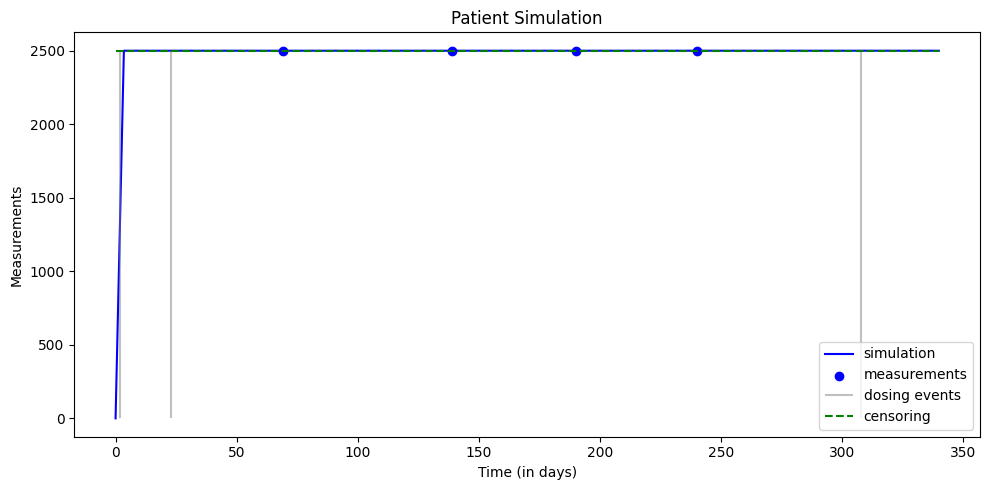

In [3]:
prior_type = ['normal', 'uniform'][0]
if model_name == 'fröhlich-simple':
    from models.froehlich_model_simple import FroehlichModelSimple
    individual_model = FroehlichModelSimple(load_best=True, prior_type=prior_type)
elif model_name == 'fröhlich-detailed':
    from models.froehlich_model_detailed import FroehlichModelDetailed
    individual_model = FroehlichModelDetailed(load_best=True, prior_type=prior_type)
elif model_name == 'fröhlich-sde':
    from models.froehlich_model_sde import FroehlichModelSDE
    individual_model = FroehlichModelSDE(load_best=True, prior_type=prior_type)    
elif model_name == 'pharmacokinetic_model':
    from models.pharmacokinetic_model import PharmacokineticModel
    individual_model = PharmacokineticModel(load_best=True)    
elif model_name == 'dePillis':
    from models.de_pillis_model import dePillisModel
    individual_model = dePillisModel(load_best=True)
else:
    raise NotImplementedError('model not implemented')

# assemble simulator and prior
trainer = individual_model.build_trainer('../networks/' + individual_model.network_name)
individual_model.plot_example()

## Load Data

In [39]:
# define how many data points are used for optimization
n_data = 4
load_real_data = False
# load data
true_pop_parameters = None
results_to_compare = None
if 'Froehlich' in individual_model.name:
    obs_data = individual_model.load_data(n_data=n_data, synthetic=not load_real_data, 
                                          load_egfp=True, load_d2egfp=False)  # if both are loaded, a 2d-list is returned
    if not load_real_data:
        true_pop_parameters = individual_model.load_synthetic_parameter(n_data=n_data)
    
    # load SDE data for comparison
    #from models.froehlich_model_sde import FroehlichModelSDE
    #model_sde = FroehlichModelSDE(load_best=True)
    #obs_data = model_sde.load_data(n_data=n_data, synthetic=True)
    #true_pop_parameters_sde = model_sde.load_synthetic_parameter(n_data=n_data)
else:
    if load_real_data:
        obs_data = individual_model.load_data(n_data=n_data)
    else:
        obs_data, true_pop_parameters = individual_model.load_data(n_data=n_data, synthetic=True, 
                                                                   return_synthetic_params=True)

n_data = len(obs_data)  # in case less data is available
print(len(obs_data), 'individuals')

4 individuals


# Estimating Population Parameters

Now we want to use the amortizer to generate samples such that we can minimize the negative log-likelihood of the data given the population parameters of the mixed effect model:
$$
    \beta^*,\Psi^* \approx 
    \underset{\beta,\Psi}{\arg\min} -\sum_i \log\left( \frac1M \sum_j^M \frac{p(\phi_j \mid \beta,\Psi)}{p(\phi_j)} \right).
$$

Remark: the objective value is not the likelihood value since the sum over $\log p(y_i)$ is missing.


$\beta$ is called ```theta_population``` in the code.


$\log \phi$ cell specific parameters, sampled from $\mathcal{N}(\beta,\Psi)$
$$
    p( \phi \mid \beta,\Psi) = (2\pi)^{-k/2}\vert \Psi\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1} \exp \left(-\frac12 (\log \phi-\beta)^T \Psi^{-1}  (\log \phi-\beta) \right)
$$

Assumptions to start with: $\Psi$ is a diagonal matrix, need better parameterization for other types

$$
    \beta^*,\Psi^* \approx
    \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log \frac1M \sum_j^M \frac{p( \phi_j \mid \beta,\Psi)}{p( \phi_j)} \right) \\
     =  \underset{\beta,\Psi}{\arg\min} -\sum_i \left(\log\left(\vert \Psi\vert^{-1/2} \right) -\log M -
    \log\left(\vert \Sigma\vert^{-1/2}\right) +\log \sum_j^M \exp \left(-\frac12 (\log\phi_j-\beta)^T \Psi^{-1}  (\log\phi_j-\beta) + \frac12 (\log\phi_j-\mu)^T \Sigma^{-1}  (\log\phi_j-\mu) \right)\right)
$$

if the prior is $p( \phi) = (2\pi)^{-k/2}\vert \Sigma\vert^{-1/2} \prod_{l=1}^k \phi_l^{-1}\exp \left(-\frac12 (\log \phi-\mu)^T \Sigma^{-1}  (\log\phi-\mu) \right)$.


For purpose of optimization we also parametrize $\Psi$ by a log-transformation since diagonal entries must be positive.

## Define Objective Function

- you have to choose the covariance format (diag or cholesky)
- if you want to use covariates, you have to specify the covariate mapping to the parameters of the log-normal distribution
- a covariate mapping takes in parameter samples (n_indv, n_samples, n_params), covariates (n_indv, n_covariates) and parameter vector with parameters needed to map the covariates into the other parameter from the mixed effects model and returns transformed parameter samples (n_indv, n_samples, n_params)

In [40]:
cov_type = ['diag', 'cholesky'][0]
use_covariates = True

mixed_effect_params_names = create_mixed_effect_model_param_names(individual_model.param_names, 
                                                                  cov_type=cov_type)

In [41]:
# build covariate mapping if needed
covariates_bounds = None
covariate_mapping = None
n_covariates_params = 0
covariates = None
covariates_names = []

if use_covariates and 'fröhlich' in model_name:
    # experiment specific gamma
    gamma_index = [ni for ni, name in enumerate(mixed_effect_params_names) if 'gamma' in name]
    gamma_index_cov = [ni for ni, name in enumerate(mixed_effect_params_names[individual_model.n_params:]) if 'gamma' in name]
    covariates_names = [name + '-d2eGFP' for name in mixed_effect_params_names if 'gamma' in name]
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-5, 5]] * n_covariates_params)
    
    mixed_effect_params_names = mixed_effect_params_names + covariates_names
    
elif use_covariates and 'clairon' in model_name:
    covariates_names = ['c_age', 'c_gender']
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-1, 1], [-1, 1]])
    
    mixed_effect_params_names = mixed_effect_params_names + covariates_names
    
elif use_covariates and 'dePillis' in model_name:
    covariates_names = ['c_not_infection_before_dose']
    n_covariates_params = len(covariates_names)
    covariates_bounds = np.array([[-10, 10]])
    
    mixed_effect_params_names = mixed_effect_params_names + covariates_names

In [42]:
if use_covariates and 'fröhlich' in model_name:
    # obs_data consists of two groups, first group is eGFP, second group is d2eGFP
    if covariates is None:
        assert len(obs_data) == 2, 'you should load two groups of data'
        covariates = np.concatenate((np.zeros(len(obs_data[0])), np.ones(len(obs_data[1]))))[:, np.newaxis]
        obs_data = np.concatenate((obs_data[0], obs_data[1]))
        n_data = len(obs_data)
        
    from inference.nlme_objective import get_inverse_covariance
    def multi_experiment_mapping(beta: np.ndarray,
                                 psi_inverse_vector: np.ndarray,
                                 covariates: np.ndarray,
                                 covariates_params: np.ndarray):
        """individual_param_i = gamma_{eGFP} * (1-c) + gamma_{d2eGFP} * c + random_effect_{eGFP}, c in {0,1}"""        
        # add param_of_cov*covariates to parameter gamma
        # covariate_params[0] > 0 expected since lifetime of d2eGFP is lower than eGFP
        beta_transformed = np.repeat(beta[np.newaxis, :], covariates.shape[0], axis=0)
        psi_inverse_vector_transformed = np.repeat(psi_inverse_vector[np.newaxis, :], covariates.shape[0], axis=0)
        psi_inverse_transformed = np.zeros((covariates.shape[0], beta.shape[0], beta.shape[0]))
                   
        # flatten since only one covariate     
        beta_transformed[:, gamma_index[0]] = beta_transformed[:, gamma_index[0]] * (1-covariates.flatten()) + covariates_params[0] * covariates.flatten()
        for i, c_i in enumerate(gamma_index_cov):
            psi_inverse_vector_transformed[:, c_i] = psi_inverse_vector[c_i] * (1-covariates.flatten()) + covariates_params[1+i] * covariates.flatten()
        
        for s_id in range(covariates.shape[0]):
            psi_inverse = get_inverse_covariance(psi_inverse_vector_transformed[s_id],
                                                 covariance_format=cov_type,
                                                 param_dim=beta.shape[0])
            psi_inverse_transformed[s_id, :, :] = psi_inverse
        return beta_transformed, psi_inverse_transformed
    
    covariate_mapping = multi_experiment_mapping
    
elif use_covariates and 'dePillis' in model_name:
    _, covariates = individual_model.load_data(n_data, synthetic=not load_real_data, 
                                            load_covariates=True)
    def previous_infection_mapping(beta: np.ndarray,
                                   psi_inverse_vector: np.ndarray,
                                   covariates: np.ndarray,
                                   covariates_params: np.ndarray):
        beta_transformed = np.repeat(beta[np.newaxis, :], covariates.shape[0], axis=0)
        beta_transformed[covariates.flatten() == 0, 0] = covariates_params[0]
        return beta_transformed
    
    covariate_mapping = previous_infection_mapping

### Analyse correlations between parameters

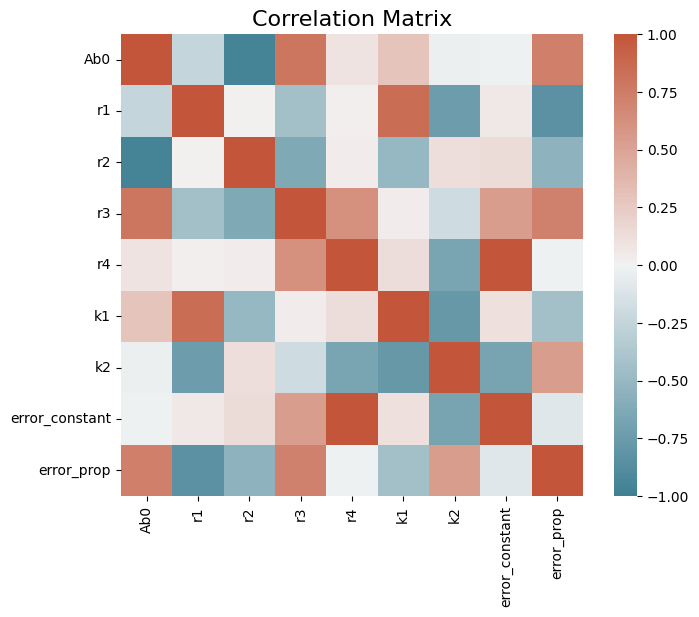

Parameter pairs of high correlation in individual posterior: []


In [43]:
high_correlation_pairs = analyse_correlation_in_posterior(model=individual_model, 
                                                          mixed_effect_params_names=mixed_effect_params_names, 
                                                          obs_data=obs_data,
                                                          threshold_corr=0.3)
print('Parameter pairs of high correlation in individual posterior:', np.array(mixed_effect_params_names)[high_correlation_pairs])

## Fixed and Random Effects

Decide which parameters to fix
- a fixed effect is modeled as a random effect with variance 0 (all parameters follow a normal distribution)
- variance of error parameters in the individual model are usually supposed to be a fixed parameter in the population model
- correlations with these error parameters are usually fixed to 0


In [44]:
if 'Froehlich' in individual_model.name:
    # fix variance of error parameters and correlations with sigma if cholesky covariance is used
    fix_names = ['var-$\sigma$'] + [name for name in mixed_effect_params_names if '\sigma' in name and 'corr_' in name]
    fixed_values = [0] * len(fix_names)
elif 'Pharmacokinetic' in individual_model.name:
    fix_error_var = ['var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fix_error_var_val = [0] * len(fix_error_var)
    # fix variance of fixed parameters
    fixed_effects_var = ['var-$\\theta_1$', 'var-$\\theta_5$', 'var-$\\theta_7$', 'var-$\\theta_8$', 
                         'var-$\\theta_{10}$', 'var-$\\theta_{12}$', 'var-$\\theta_{13}$']
    fixed_effects_var_val = [0] * len(fixed_effects_var)
    # fix mean of random effect
    random_effect_mean = ['pop-$\eta_4$']
    random_effect_mean_val = [0]
    
    # put all fixed parameters together
    fix_names = fix_error_var + fixed_effects_var + random_effect_mean
    fixed_values = fix_error_var_val + fixed_effects_var_val + random_effect_mean_val
    
    # if correlations are used, only allow the same as in the original model
    # hence correlations with the error parameter are fixed as well
    if cov_type == 'cholesky':
        non_fix_corr = ['corr_$\\theta_2-\\eta_1$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\theta_6-\\eta_2$', 
                        'corr_$\\theta_4-\\eta_3$_$\\eta_4$']
        fixed_corr = [x for x in mixed_effect_params_names if 'corr_' in x and x not in non_fix_corr]
        fix_names += fixed_corr
        fixed_values += [0] * len(fixed_corr)
    
elif 'dePillis' in individual_model.name:
    fix_names = ['pop-k2', 'var-error_constant', 'var-error_prop']#, 'c_not_infection_before_dose']
    fixed_values = [np.log(55.), 0, 0]#, -5]
else:
    raise NotImplementedError('model not yet implemented')
    
# "fix" is here in the context of parameters which are not optimized
fixed_indices, fixed_values = create_fixed_params(fix_names=fix_names, 
                                                  fixed_values=fixed_values,
                                                  params_list=mixed_effect_params_names, 
                                                  fix_low_correlation=False,  # only applies to cholesky covariance
                                                  high_correlation_pairs=high_correlation_pairs)
print(mixed_effect_params_names)
# note: inf values in fixed_values will be set to upper or lower bound respectively

['pop-Ab0', 'pop-r1', 'pop-r2', 'pop-r3', 'pop-r4', 'pop-k1', 'pop-k2', 'pop-error_constant', 'pop-error_prop', 'var-Ab0', 'var-r1', 'var-r2', 'var-r3', 'var-r4', 'var-k1', 'var-k2', 'var-error_constant', 'var-error_prop', 'c_not_infection_before_dose']


In [45]:
fixed_indices, unique_indices = np.unique(np.array(fixed_indices), return_index=True)
fixed_values = np.array(fixed_values)[unique_indices]

# Run Population Optimization

In [46]:
%%time
pypesto_result, obj_fun_amortized, pesto_problem = run_population_optimization(
    individual_model=individual_model,
    data=obs_data,
    param_names=mixed_effect_params_names,
    cov_type=cov_type,
    n_multi_starts=20,
    n_samples_opt=250,
    covariates_bounds=covariates_bounds,
    covariates=covariates,
    n_covariates_params=n_covariates_params,
    covariate_mapping=covariate_mapping,
    huber_loss=False,
    x_fixed_indices=fixed_indices,
    x_fixed_vals=fixed_values,
    #file_name=f'../Experiments/results_nonmem/{model_name}_{cov_type}.hdf5',
    verbose=True,
    trace_record=False,
    pesto_multi_processes=10,
    use_result_as_start=False,
    #result=pypesto_result
)

print(pypesto_result.optimize_result.summary())

Multi-start optimization:   0%|          | 0/2 [00:00<?, ?it/s]

                               free    lb_full    ub_full
pop-Ab0                        True  -4.405619   9.010789
pop-r1                         True -11.313374   2.103034
pop-r2                         True  -7.401351   6.015057
pop-r3                         True -18.221129  -4.804722
pop-r4                         True -18.221129  -4.804722
pop-k1                         True  -2.893567   7.498738
pop-k2                        False  -1.188819   9.203486
pop-error_constant             True  -5.302585   0.697415
pop-error_prop                 True  -5.302585   0.697415
$-\log$ (var-Ab0)              True  -7.323056   6.093352
$-\log$ (var-r1)               True  -7.323056   6.093352
$-\log$ (var-r2)               True  -7.323056   6.093352
$-\log$ (var-r3)               True  -7.323056   6.093352
$-\log$ (var-r4)               True  -7.323056   6.093352
$-\log$ (var-k1)               True  -7.323056   6.093352
$-\log$ (var-k2)               True  -7.323056   6.093352
$-\log$ (var-e


Multi-start optimization: 100%|██████████| 2/2 [00:57<00:00, 28.88s/it]


## Optimization Result 

* number of starts: 20 
* best value: -11.765091447039126, id=batch_0_8
* worst value: 25.592479368986105, id=batch_1_9
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 22.611s
	* Maximum execution time: 27.337s,	id=batch_0_1
	* Minimum execution time: 15.006s,	id=batch_0_5
* summary of optimizer messages:

  |   Count | Message                                         |
  |--------:|:------------------------------------------------|
  |      20 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |

* best value found (approximately) 1 time(s)
* number of plateaus found: 0

A summary of the best run:

### Optimizer Result

* optimizer used: <ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>
* message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 
* number of evaluations: 247
* time taken to optimize: 22.819s
* startpoint: [ -0.21130796  -1.2249618    0.21047801 -15.24735201 -16.41813664
  -0.3033399   -1.

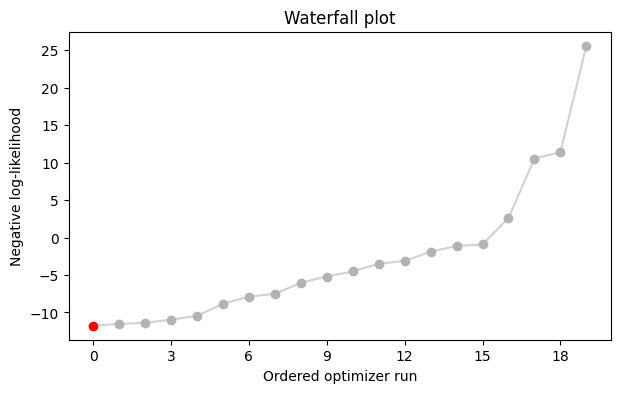

In [47]:
ax = visualize.waterfall(pypesto_result, scale_y='lin', size=(7, 4))
ax.set_ylabel('Negative log-likelihood');
#plt.savefig(f'../Plots/sde_waterfall.png', dpi=600)

In [48]:
from pypesto import visualize

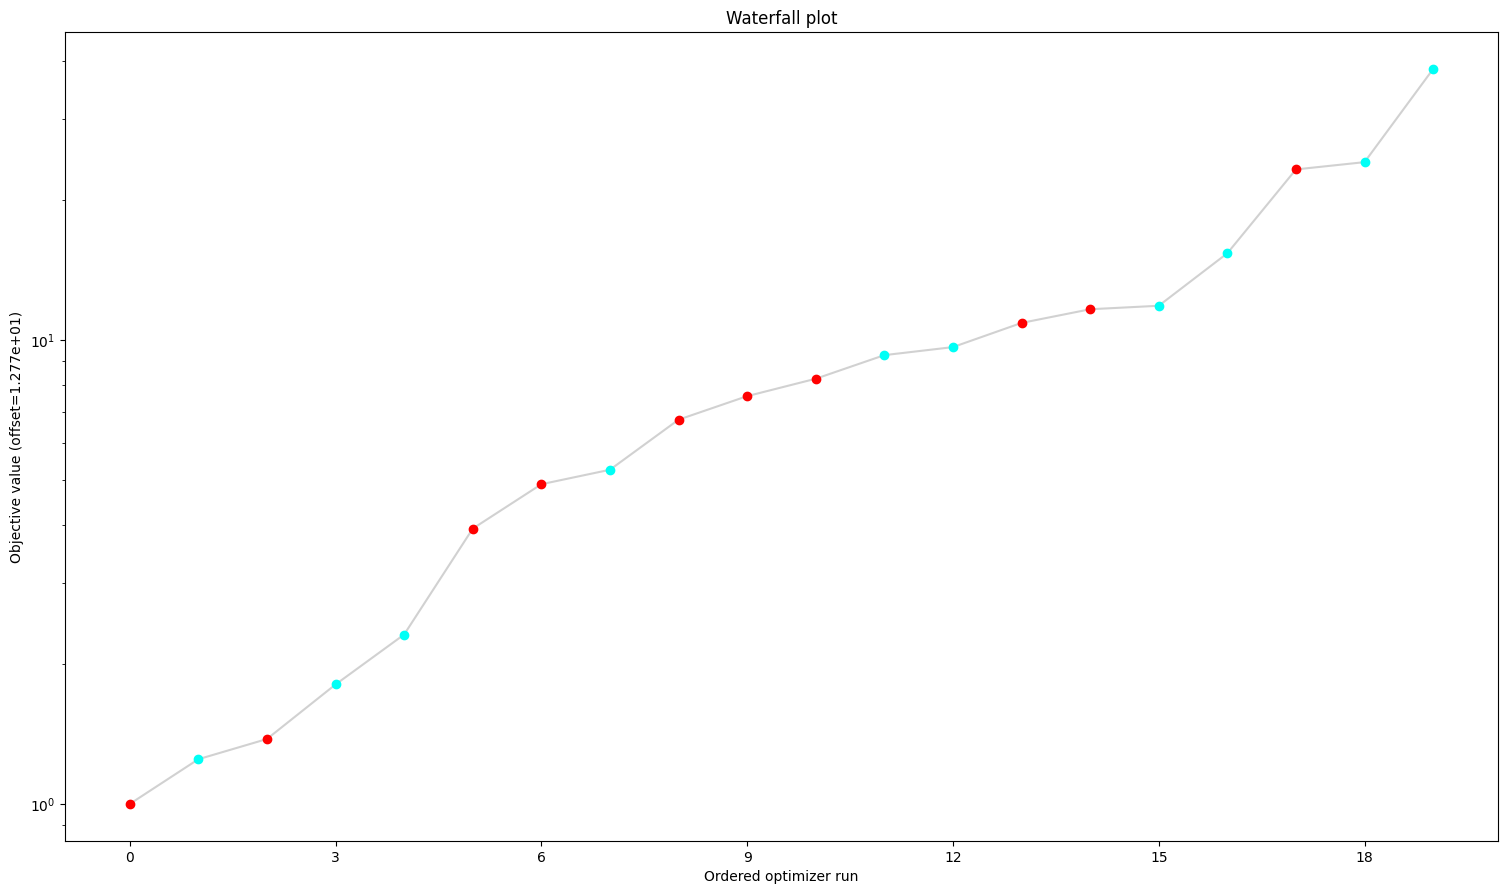

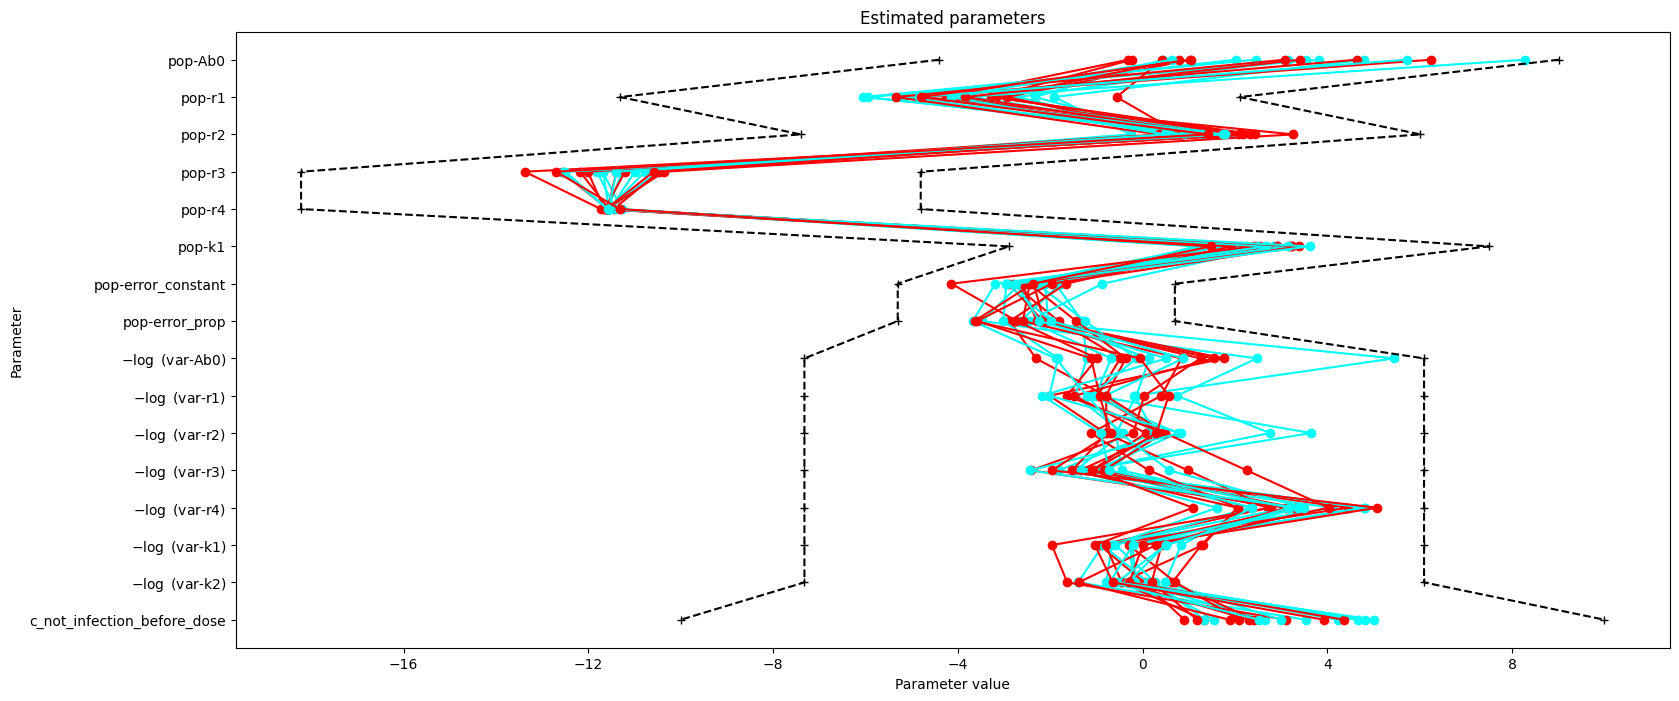

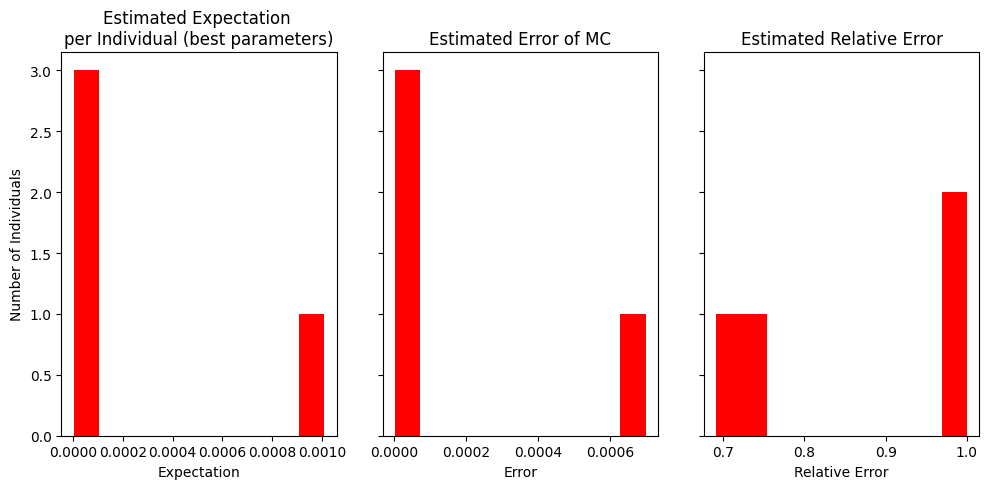

In [49]:
visualize_pesto_result(pypesto_result, obj_fun_amortized=obj_fun_amortized)

In [50]:
# show best result
results = pypesto_result.optimize_result.x
estimated_beta, psi_inverse, estimated_psi_vector, estimated_covariates_params = obj_fun_amortized.get_params(results[-1])
estimated_psi = np.linalg.inv(psi_inverse)
estimated_var = estimated_psi.diagonal()
estimated_corr = estimated_psi[np.tril_indices(obj_fun_amortized.param_dim, k=-1)]

display(pd.DataFrame(estimated_beta,
                     index=mixed_effect_params_names[:individual_model.n_params],
                     columns=['estimated population parameters']))
display(pd.DataFrame(estimated_var,
                     index=mixed_effect_params_names[individual_model.n_params:individual_model.n_params*2],
                     columns=['estimated population parameters']))
if cov_type == 'cholesky':
    display(pd.DataFrame(estimated_corr,
                         index=mixed_effect_params_names[individual_model.n_params*2:],
                         columns=['estimated population parameters']))
    
display(pd.DataFrame(np.var([r for r in results], axis=0),
                     index=pypesto_result.problem.x_names,
                     columns=['variance of multi-start results']))

,estimated population parameters
pop-Ab0,3.528673
pop-r1,-3.671207
pop-r2,1.331332
pop-r3,-10.491285
pop-r4,-11.578127
pop-k1,1.639716
pop-k2,4.007333
pop-error_constant,-1.774397
pop-error_prop,-2.642700


,estimated population parameters
var-Ab0,0.004312
var-r1,1.196014
var-r2,0.774940
var-r3,6.135139
var-r4,0.016563
var-k1,2.358609
var-k2,4.038538
var-error_constant,0.001000
var-error_prop,0.001000


,variance of multi-start results
pop-Ab0,5.283580e+00
pop-r1,1.850790e+00
pop-r2,6.847201e-01
pop-r3,7.037554e-01
pop-r4,1.111696e-02
pop-k1,5.315187e-01
pop-k2,7.888609e-31
pop-error_constant,4.320766e-01
pop-error_prop,5.347640e-01
$-\log$ (var-Ab0),3.031332e+00


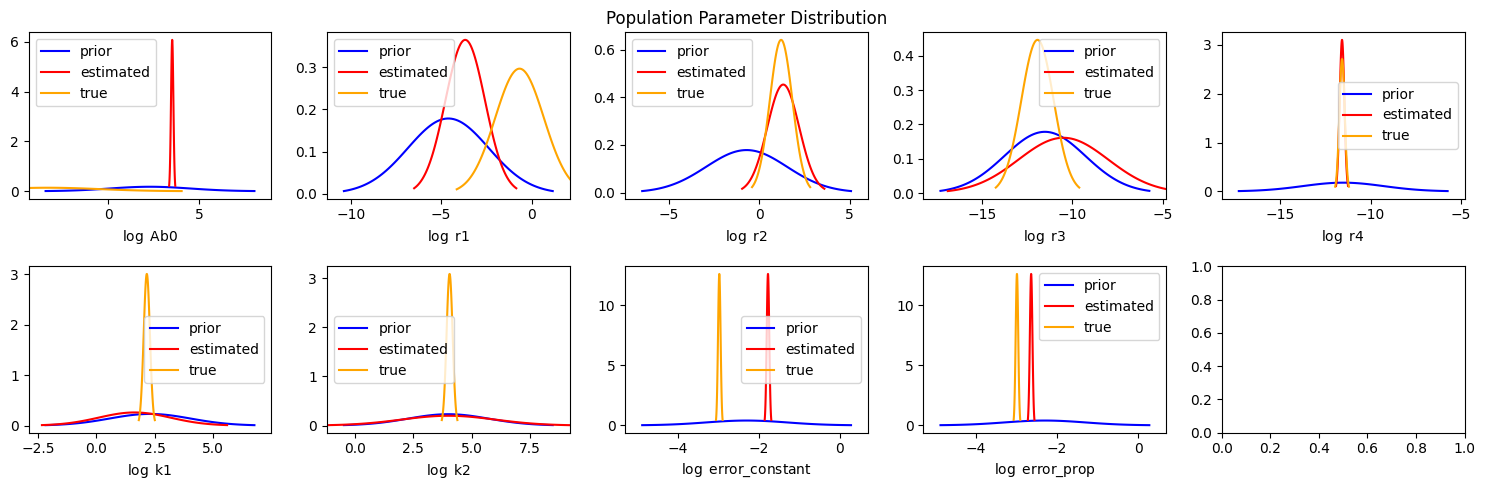

In [51]:
# _ = plot_normal_distributions(individual_model.prior_mean, individual_model.prior_cov,
#                               title='Prior Parameter Distribution with Individual Posterior Samples',
#                               label='prior',
#                               posterior_samples=obj_fun_amortized.param_samples,
#                               lb=pypesto_result.problem.lb_full,
#                               ub=pypesto_result.problem.ub_full,
#                               param_names_plot=individual_model.log_param_names)

ax = plot_normal_distributions(individual_model.prior_mean, individual_model.prior_cov,
                               title='Prior Parameter Distribution with Individual Posterior Samples',
                               label='prior',
                               #posterior_samples=obj_fun_amortized.param_samples,
                               lb=pypesto_result.problem.lb_full,
                               ub=pypesto_result.problem.ub_full,
                               param_names_plot=individual_model.log_param_names)

ax = plot_normal_distributions(estimated_beta, estimated_psi,
                               title='Population Parameter Distribution',
                               label='estimated',
                               lb=pypesto_result.problem.lb_full,
                               ub=pypesto_result.problem.ub_full,
                               param_names_plot=individual_model.log_param_names,
                               ax=ax,
                               color='red')

if true_pop_parameters is not None:
    if true_pop_parameters.ndim == 2:
        true_mean = np.mean(true_pop_parameters, axis=0)
        true_cov = np.diag(np.var(true_pop_parameters, axis=0))
    else:
        true_mean = true_pop_parameters[:individual_model.n_params]
        true_cov = np.diag(true_pop_parameters[individual_model.n_params:])
    true_cov[true_cov < 0.001] = 0.001  # smaller cannot be estimated

    ax = plot_normal_distributions(true_mean,
                                   true_cov,
                                   title='Population Parameter Distribution',
                                   label='true',
                                   #posterior_samples=obj_fun_amortized.param_samples,
                                   lb=pypesto_result.problem.lb_full,
                                   ub=pypesto_result.problem.ub_full,
                                   param_names_plot=individual_model.log_param_names,
                                   ax=ax,
                                   color='orange')
for a in ax.flatten()[:estimated_beta.size]:
    a.legend()
plt.show()

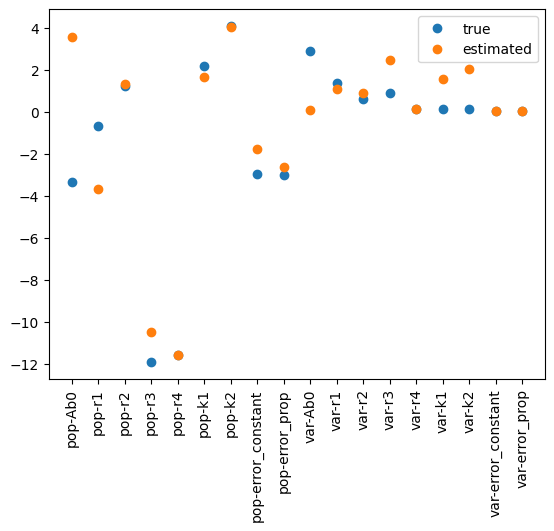

In [52]:
# plot estimates parameters vs true parameters
if true_pop_parameters is not None:
    plt_true = np.concatenate((true_mean, np.sqrt(true_cov.diagonal())))
    plt.plot(np.arange(0, plt_true.size), plt_true, 'o', label='true')
plt_estimated = np.concatenate((estimated_beta, np.sqrt(estimated_psi.diagonal())))
plt.plot(np.arange(0, plt_estimated.size), plt_estimated, 'o', label='estimated')
plt.xticks(np.arange(0, plt_estimated.size), mixed_effect_params_names[:-n_covariates_params], rotation=90)
plt.legend()
plt.show()

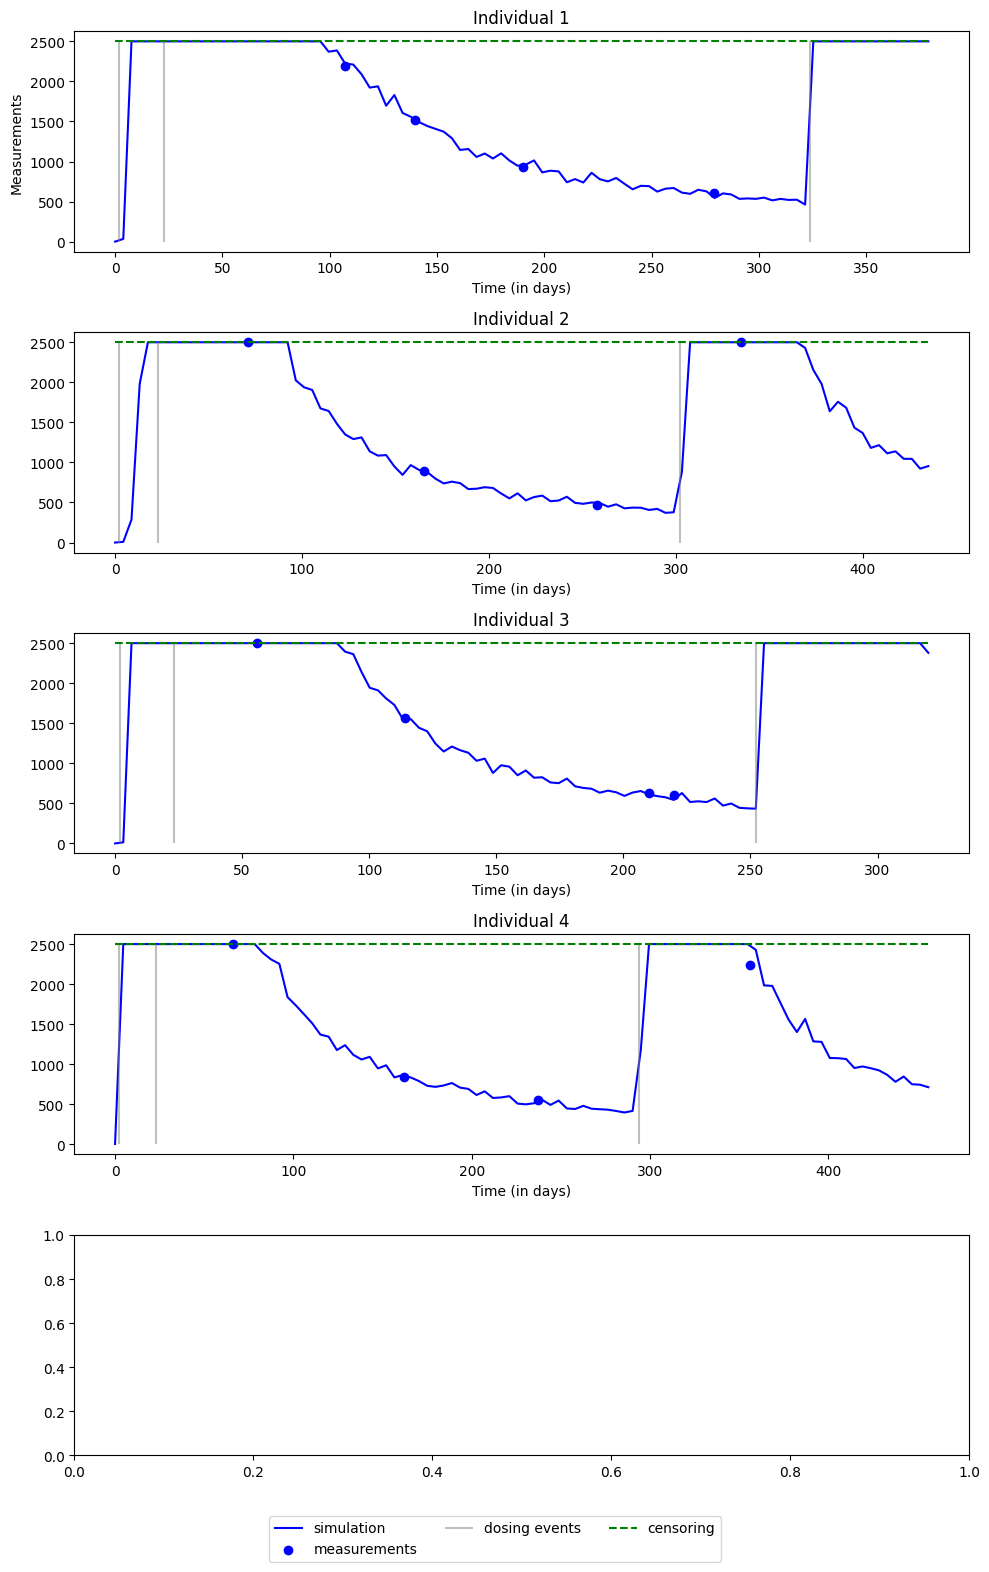

In [53]:
data_posterior_draws = individual_model.draw_posterior_samples(data=obs_data[:10], n_samples=100)

rows = 5
fig, ax = plt.subplots(rows, int(np.ceil(len(obs_data[:10]) / rows)), tight_layout=True, 
                       figsize=(10, rows*3), sharey='row')
axis = ax.flatten()
    
for p_id in range(len(obs_data[:10])):
    axis[p_id] = individual_model.prepare_plotting(obs_data[:10][p_id], true_pop_parameters[p_id], axis[p_id], with_noise=True)
    _, labels = axis[p_id].get_legend_handles_labels()
    axis[p_id].set_title(f'Individual {p_id+1}')
    if p_id % rows != 0:
        axis[p_id].set_ylabel('')

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.01))
plt.show()

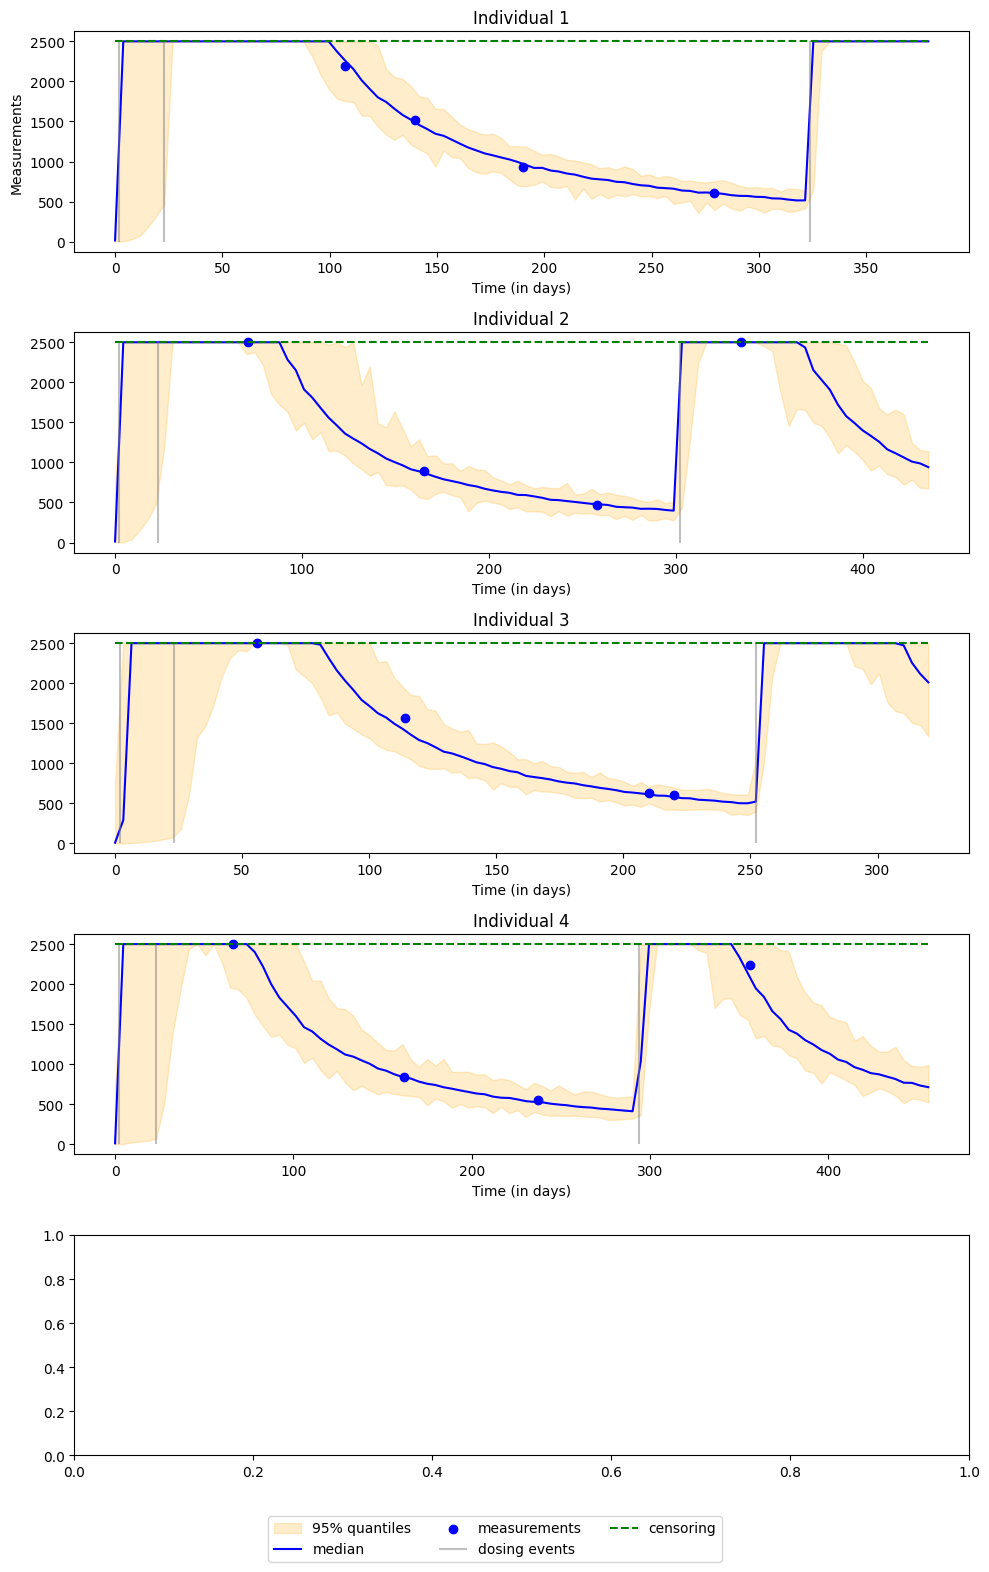

In [54]:
data_posterior_draws = individual_model.draw_posterior_samples(data=obs_data[:10], n_samples=100)

rows = 5
fig, ax = plt.subplots(rows, int(np.ceil(len(obs_data[:10]) / rows)), tight_layout=True, 
                       figsize=(10, rows*3), sharey='row')
axis = ax.flatten()
    
for p_id in range(len(obs_data[:10])):
    axis[p_id] = individual_model.prepare_plotting(obs_data[:10][p_id], data_posterior_draws[p_id], axis[p_id], with_noise=True)
    _, labels = axis[p_id].get_legend_handles_labels()
    axis[p_id].set_title(f'Individual {p_id+1}')
    if p_id % rows != 0:
        axis[p_id].set_ylabel('')

fig.legend(labels, ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.01))
plt.show()

In [ ]:
if 'fröhlich' in model_name:
    plot_real_vs_synthetic(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           ylim=(-1.,1.),
                           seed=0)
    plot_real_and_estimated(estimated_mean=estimated_beta,
                           estimated_cov=estimated_psi,
                           data=obs_data[:n_data//2] if n_covariates_params > 0 else obs_data,
                           model_name=individual_model.name,
                           n_trajectories=n_data//2 if n_covariates_params > 0 else n_data,
                           simulator=individual_model.simulator,
                           seed=0)
    
    if n_covariates_params > 0:
        print(estimated_covariates_params)
        estimated_beta_d2, estimated_inv_psi_d2 = covariate_mapping(estimated_beta, 
                                                                    estimated_psi_vector, 
                                                                    np.ones(1), 
                                                                    estimated_covariates_params)
        print(estimated_beta[1], estimated_beta_d2[0, 1])
        estimated_beta_d2 = estimated_beta_d2[-1]  # only second group, mean is the same for the whole group
        estimated_inv_psi_d2 = estimated_inv_psi_d2[-1]
        estimated_psi_d2 = np.linalg.inv(estimated_inv_psi_d2)
        
        plot_real_vs_synthetic(estimated_mean=estimated_beta_d2,
                           estimated_cov=estimated_psi_d2,
                           data=obs_data[n_data//2:],
                           model_name=individual_model.name,
                           n_trajectories=n_data//2,
                           simulator=individual_model.simulator,
                           ylim=(-1.,1.),
                           seed=0)
        plot_real_and_estimated(estimated_mean=estimated_beta_d2,
                               estimated_cov=estimated_psi_d2,
                               data=obs_data[n_data//2:],
                               model_name=individual_model.name,
                               n_trajectories=n_data//2,
                               simulator=individual_model.simulator,
                               seed=0)

# Bayesian Sampling

Since our amortized inference is very efficient, we can use it to sample from the posterior distribution of the population parameters.

In [ ]:
# build neg log prior
inv_var_prior_mean = -np.log(individual_model.prior_cov.diagonal())
inv_var_prior_std = np.ones(len(inv_var_prior_mean))*5
prior = NegLogParameterPriors(
    [
        {'index': pesto_problem.full_index_to_free_index(i), 'density_fun': lambda x: -stats.norm.logpdf(x, loc=individual_model.prior_mean[i], scale=np.sqrt(individual_model.prior_cov.diagonal()[i]))}
     for i in range(individual_model.n_params) if i not in fixed_indices
    ] + [
        {'index': pesto_problem.full_index_to_free_index(i+individual_model.n_params), 'density_fun': lambda x: -stats.norm.logpdf(x, loc=inv_var_prior_mean[i], scale=inv_var_prior_std[i])}
     for i in range(individual_model.n_params) if i+individual_model.n_params not in fixed_indices
    ] + [
        {'index': pesto_problem.full_index_to_free_index(i+individual_model.n_params*2), 'density_fun': lambda x: -stats.norm.logpdf(x, loc=0, scale=1)}
     for i in range(len(mixed_effect_params_names)-individual_model.n_params*2) if i+individual_model.n_params*2 not in fixed_indices
    ]
)

In [ ]:
bayesian_problem = Problem(
    objective=AggregatedObjective([Objective(obj_fun_amortized), prior]),
    lb=pesto_problem.lb_full, 
    ub=pesto_problem.ub_full, 
    x_names=pesto_problem.x_names,
    x_scales=pesto_problem.x_scales,
    x_fixed_indices=pesto_problem.x_fixed_indices,
    x_fixed_vals=pesto_problem.x_fixed_vals,
    x_priors_defs=prior,
)

In [ ]:
sampler = sample.AdaptiveMetropolisSampler()
x0 = pesto_problem.get_reduced_vector(pypesto_result.optimize_result.x[0])

In [ ]:
pypesto_result = sample.sample(
    bayesian_problem,
    n_samples=100000,
    sampler=sampler,
    result=pypesto_result,
    x0=x0,
    #filename=f'../Experiments/results_nonmem/sampling_{model_name}_{cov_type}.hdf5',
    overwrite=True
)

In [ ]:
sample.geweke_test(pypesto_result)
ax = visualize.sampling_1d_marginals(pypesto_result)

In [ ]:
# extract 95% credible intervals
param_quantiles = np.quantile(pypesto_result.sample_result.trace_x, [0.01, 0.99], axis=1)
param_quantiles = param_quantiles[:, 0, :]
param_median = np.median(pypesto_result.sample_result.trace_x, axis=1).flatten()
# compute difference from median to 95% quantile
param_quantiles_dif = np.abs(param_median-param_quantiles)

In [ ]:
import re

In [ ]:
if 'Pharmacokinetic' in individual_model.name:
    # load SAEM data
    raw_data_SAEM = pd.read_csv(f'../Experiments/results_nonmem/SAEM_ordered_population_parameters_w_corr.csv', delimiter=',',
                               index_col=0, header=0)
    raw_data_SAEM[['omega_V_2', 'omega_CLP', 'omega_V_3', 'omega_f_m']] = raw_data_SAEM[['omega_V_2', 'omega_CLP', 'omega_V_3', 'omega_f_m']].values **2
    raw_data_SAEM[['ay2', 'ay2']] = np.log(raw_data_SAEM[['ay2', 'ay2']].values)
    #likelihoods = pd.read_csv(f'../Experiments/results_nonmem/ordered_likelihoods.csv', delimiter=',',
    #                           index_col=0, header=0)
    df_mapping = {'pop-$\\theta_1$': 'k_a_pop',
     'pop-$\\theta_2-\\eta_1$': 'V_2_pop',
     'pop-$\\theta_4-\\eta_3$': 'CLP_pop',
     'pop-$\\theta_5$': 'CLM_pop',
     'pop-$\\theta_6-\\eta_2$': 'V_3_pop',
     'pop-$\\theta_7$': 'Q_34_pop',
     'pop-$\\theta_8$': 'V_4_pop',
     'pop-$\\theta_{10}$': 'Q_25_pop',
     'pop-$\\theta_{12}$': 'ay2', 
     'pop-$\\theta_{13}$': 'ay3',
     'pop-$\\eta_4$': 0,
     'var-$\\theta_1$': 0,
     'var-$\\theta_2-\\eta_1$': 'omega_V_2',
     'var-$\\theta_4-\\eta_3$': 'omega_CLP',
     'var-$\\theta_5$': 0,
     'var-$\\theta_6-\\eta_2$': 'omega_V_3',
     'var-$\\theta_7$': 0,
     'var-$\\theta_8$': 0,
     'var-$\\theta_{10}$': 0,
     'var-$\\theta_{12}$': 0,
     'var-$\\theta_{13}$': 0,
     'var-$\\eta_4$': 'omega_f_m',
     'corr_$\\theta_1$_$\\theta_2-\\eta_1$': 0,
     'corr_$\\theta_1$_$\\theta_4-\\eta_3$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_4-\\eta_3$': 'corr_V_2_CLP', #'OMEGA(3,1)',                     
     'corr_$\\theta_1$_$\\theta_5$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_5$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_5$': 0,
     'corr_$\\theta_1$_$\\theta_6-\\eta_2$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_6-\\eta_2$': 'corr_V_3_V_2', #'OMEGA(2,1)',
     'corr_$\\theta_4-\\eta_3$_$\\theta_6-\\eta_2$': 'corr_V_3_CLP', #'OMEGA(3,2)',
     'corr_$\\theta_5$_$\\theta_6-\\eta_2$': 0,
     'corr_$\\theta_1$_$\\theta_7$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_7$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_7$': 0,
     'corr_$\\theta_5$_$\\theta_7$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_7$': 0,
     'corr_$\\theta_1$_$\\theta_8$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_8$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_8$': 0,
     'corr_$\\theta_5$_$\\theta_8$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_8$': 0,
     'corr_$\\theta_7$_$\\theta_8$': 0,
     'corr_$\\theta_1$_$\\theta_{10}$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_{10}$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_{10}$': 0,
     'corr_$\\theta_5$_$\\theta_{10}$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_{10}$': 0,
     'corr_$\\theta_7$_$\\theta_{10}$': 0,
     'corr_$\\theta_8$_$\\theta_{10}$': 0,
     'corr_$\\theta_1$_$\\theta_{12}$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_{12}$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_{12}$': 0,
     'corr_$\\theta_5$_$\\theta_{12}$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_{12}$': 0,
     'corr_$\\theta_7$_$\\theta_{12}$': 0,
     'corr_$\\theta_8$_$\\theta_{12}$': 0,
     'corr_$\\theta_{10}$_$\\theta_{12}$': 0,
     'corr_$\\theta_1$_$\\theta_{13}$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_{13}$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_{13}$': 0,
     'corr_$\\theta_5$_$\\theta_{13}$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_{13}$': 0,
     'corr_$\\theta_7$_$\\theta_{13}$': 0,
     'corr_$\\theta_8$_$\\theta_{13}$': 0,
     'corr_$\\theta_{10}$_$\\theta_{13}$': 0,
     'corr_$\\theta_{12}$_$\\theta_{13}$': 0,
     'corr_$\\theta_1$_$\\eta_4$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\eta_4$': 'corr_f_m_V_2', #'OMEGA(4,1)',
     'corr_$\\theta_4-\\eta_3$_$\\eta_4$': 'corr_f_m_CLP', #'OMEGA(4,3)',
     'corr_$\\theta_5$_$\\eta_4$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\eta_4$': 'corr_f_m_V_3', #'OMEGA(4,2)',
     'corr_$\\theta_7$_$\\eta_4$': 0,
     'corr_$\\theta_8$_$\\eta_4$': 0,
     'corr_$\\theta_{10}$_$\\eta_4$': 0,
     'corr_$\\theta_{12}$_$\\eta_4$': 0,
     'corr_$\\theta_{13}$_$\\eta_4$': 0}
    
    # iterater over raw_data and rename columns if column name is a value
    # if column does not exist in values of df_mapping, drop it
    for col in raw_data_SAEM.columns:
        if col in df_mapping.values():
            raw_data_SAEM.rename(columns={col: list(df_mapping.keys())[list(df_mapping.values()).index(col)]}, inplace=True)
        else:
            raw_data_SAEM.drop(columns=[col], inplace=True)
    #raw_data_SAEM = raw_data_SAEM.iloc[:1]
    
    for col in raw_data_SAEM:
        if 'corr' in col:
            # find which etas are in this column
            etas = [x for x in re.findall(r'\\eta_\d+', col)]
            var = []
            if '\\eta_1' in etas:
                var.append(raw_data_SAEM['var-$\\theta_2-\\eta_1$'].values)
            if '\\eta_2' in etas:
                var.append(raw_data_SAEM['var-$\\theta_6-\\eta_2$'].values)
            if '\\eta_3' in etas:
                var.append(raw_data_SAEM['var-$\\theta_4-\\eta_3$'].values)
            if '\\eta_4' in etas:
                var.append(raw_data_SAEM['var-$\\eta_4$'].values)
            raw_data_SAEM[col] = raw_data_SAEM[col].values * np.prod(np.sqrt(var), axis=0)

In [ ]:
if 'Pharmacokinetic' in individual_model.name:    
    # load nonmem data
    raw_data = pd.read_csv(f'../Experiments/results_nonmem/retries_sunitinib_lognor.csv', delimiter=',',
                               index_col=0, header=0)
    raw_data['time'] = raw_data['subprob_est_time'] + raw_data['subprob_cov_time']
    raw_data['time'] = np.nanmax(raw_data[['time', 'CPU-time [s]']], axis=1)
    raw_data[['OMEGA(3,1)', 'OMEGA(3,2)', 'OMEGA(4,1)', 'OMEGA(4,2)', 'OMEGA(4,3)']] = raw_data[['OMEGA(3,1)', 'OMEGA(3,2)', 'OMEGA(4,1)', 'OMEGA(4,2)', 'OMEGA(4,3)']].values**2


    df_mapping = {'pop-$\\theta_1$': '1 = K12  Absorption rate constant',
     'pop-$\\theta_2-\\eta_1$': '2 = V2  Central volume of distribution of sunitinib',
     'pop-$\\theta_4-\\eta_3$': '4 = CLP  Clearance of sunitinib',
     'pop-$\\theta_5$': '5 = CLM  Clearance of SU12662',
     'pop-$\\theta_6-\\eta_2$': '6 = V3  Central volume of distribution of SU12662',
     'pop-$\\theta_7$': '7 = Q34  Inter-compartmental clearance of SU12662',
     'pop-$\\theta_8$': '8 = V4  Peripheral volumes of distribution of SU12662',
     'pop-$\\theta_{10}$': '10 = Q25  Inter-compartmental clearance of Sunitinib',
     'pop-$\\theta_{12}$': '12 =  Prop. Error Suni', 
     'pop-$\\theta_{13}$': '13 = Prop. Error Metab',
     'pop-$\\eta_4$': 0,
     'var-$\\theta_1$': 0,
     'var-$\\theta_2-\\eta_1$': '1 IIV V2',
     'var-$\\theta_4-\\eta_3$': '3 IIV CLP',
     'var-$\\theta_5$': 0,
     'var-$\\theta_6-\\eta_2$': '2 IIV V3',
     'var-$\\theta_7$': 0,
     'var-$\\theta_8$': 0,
     'var-$\\theta_{10}$': 0,
     'var-$\\theta_{12}$': 0,
     'var-$\\theta_{13}$': 0,
     'var-$\\eta_4$': '4 IIV FM',
     'corr_$\\theta_1$_$\\theta_2-\\eta_1$': 0,
     'corr_$\\theta_1$_$\\theta_4-\\eta_3$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_4-\\eta_3$': 'OMEGA(3,1)',
     'corr_$\\theta_1$_$\\theta_5$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_5$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_5$': 0,
     'corr_$\\theta_1$_$\\theta_6-\\eta_2$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_6-\\eta_2$': 'OMEGA(2,1)',
     'corr_$\\theta_4-\\eta_3$_$\\theta_6-\\eta_2$': 'OMEGA(3,2)',
     'corr_$\\theta_5$_$\\theta_6-\\eta_2$': 0,
     'corr_$\\theta_1$_$\\theta_7$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_7$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_7$': 0,
     'corr_$\\theta_5$_$\\theta_7$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_7$': 0,
     'corr_$\\theta_1$_$\\theta_8$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_8$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_8$': 0,
     'corr_$\\theta_5$_$\\theta_8$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_8$': 0,
     'corr_$\\theta_7$_$\\theta_8$': 0,
     'corr_$\\theta_1$_$\\theta_{10}$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_{10}$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_{10}$': 0,
     'corr_$\\theta_5$_$\\theta_{10}$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_{10}$': 0,
     'corr_$\\theta_7$_$\\theta_{10}$': 0,
     'corr_$\\theta_8$_$\\theta_{10}$': 0,
     'corr_$\\theta_1$_$\\theta_{12}$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_{12}$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_{12}$': 0,
     'corr_$\\theta_5$_$\\theta_{12}$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_{12}$': 0,
     'corr_$\\theta_7$_$\\theta_{12}$': 0,
     'corr_$\\theta_8$_$\\theta_{12}$': 0,
     'corr_$\\theta_{10}$_$\\theta_{12}$': 0,
     'corr_$\\theta_1$_$\\theta_{13}$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\theta_{13}$': 0,
     'corr_$\\theta_4-\\eta_3$_$\\theta_{13}$': 0,
     'corr_$\\theta_5$_$\\theta_{13}$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\theta_{13}$': 0,
     'corr_$\\theta_7$_$\\theta_{13}$': 0,
     'corr_$\\theta_8$_$\\theta_{13}$': 0,
     'corr_$\\theta_{10}$_$\\theta_{13}$': 0,
     'corr_$\\theta_{12}$_$\\theta_{13}$': 0,
     'corr_$\\theta_1$_$\\eta_4$': 0,
     'corr_$\\theta_2-\\eta_1$_$\\eta_4$': 'OMEGA(4,1)',
     'corr_$\\theta_4-\\eta_3$_$\\eta_4$': 'OMEGA(4,3)',
     'corr_$\\theta_5$_$\\eta_4$': 0,
     'corr_$\\theta_6-\\eta_2$_$\\eta_4$': 'OMEGA(4,2)',
     'corr_$\\theta_7$_$\\eta_4$': 0,
     'corr_$\\theta_8$_$\\eta_4$': 0,
     'corr_$\\theta_{10}$_$\\eta_4$': 0,
     'corr_$\\theta_{12}$_$\\eta_4$': 0,
     'corr_$\\theta_{13}$_$\\eta_4$': 0,
    'likelihood': 'ofv',
    'computation_time': 'time'}
    
    # iterater over raw_data and rename columns if column name is a value
    # if column does not exist in values of df_mapping, drop it
    for col in raw_data.columns:
        if col in df_mapping.values():
            raw_data.rename(columns={col: list(df_mapping.keys())[list(df_mapping.values()).index(col)]}, inplace=True)
        else:
            raw_data.drop(columns=[col], inplace=True)
            
    for col in raw_data.columns:
        if col[:3] == 'pop':
            raw_data[col] = np.log(np.abs(raw_data[col]))
        
    # update correlations to covariances    
    for col in raw_data:
        if 'corr' in col:
            # find which etas are in this column
            etas = [x for x in re.findall(r'\\eta_\d+', col)]
            var = []
            if '\\eta_1' in etas:
                var.append(raw_data['var-$\\theta_2-\\eta_1$'].values)
            if '\\eta_2' in etas:
                var.append(raw_data['var-$\\theta_6-\\eta_2$'].values)
            if '\\eta_3' in etas:
                var.append(raw_data['var-$\\theta_4-\\eta_3$'].values)
            if '\\eta_4' in etas:
                var.append(raw_data['var-$\\eta_4$'].values)
            raw_data[col] = raw_data[col].values * np.prod(np.sqrt(var), axis=0)
            
            
    #old_columns = raw_data.columns.copy()
    #for name in df_mapping.keys():
    #    if name not in raw_data.columns:
    #        raw_data[name] = 0
            
    raw_data.sort_values(by=['likelihood'], inplace=True)
    print(raw_data.shape)
    # drop nan
    #raw_data.dropna(inplace=True)
    #print(raw_data.shape)
    
    # make an error plot with median and one std per parameter
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    i, j, l  = 0, 0, 0
    plot_names = []
    
    results = pypesto_result.optimize_result.x
    covs = []
    for r in results:
        estimated_beta, psi_inverse, estimated_psi_vector, estimated_covariates_params = obj_fun_amortized.get_params(r)
        estimated_psi = np.linalg.inv(psi_inverse)
        covs.append(estimated_psi)
    
    for name in mixed_effect_params_names:
        if name in raw_data.columns:  # other parameters are 0 anyway
                
            # plot amortized parameter estimates
            if name[:3] == 'var':
                # make variance parameters
                print('nonmem', raw_data[name].median())
                print(name, np.exp(-param_quantiles_dif[:, i-l])[:, np.newaxis])
                ax.errorbar(
                        y=np.exp(-param_median[i]),
                        #y=np.median(np.exp(-np.array(pypesto_result.optimize_result.x)[:, i])), 
                        x=i,
                        #yerr=np.std(np.exp(-np.array(pypesto_result.optimize_result.x)[:, i]))*3, 
                        yerr=np.exp(-param_quantiles_dif[:, i-l])[:, np.newaxis],
                        fmt='o', color='blue', label='amortized approach' if i == 0 else None, zorder=3)
            elif name[:4] == 'corr':
                if name not in non_fix_corr:
                    continue
                # make correlation parameters
                # extract the correct parameters values
                corr_values = []
                for cov in covs:
                    corr_values.append(cov[np.tril_indices(obj_fun_amortized.param_dim, k=-1)][j])
                
                ax.errorbar(y=np.median(corr_values), x=i,
                        yerr=np.std(corr_values)*3, 
                        fmt='o', color='blue', label='amortized approach' if i == 0 else None, zorder=3)
            else:
                ax.errorbar(
                        y=param_median[i],
                        #y=np.median(np.array(pypesto_result.optimize_result.x)[:, i])
                        x=i,
                        #yerr=np.std(np.array(pypesto_result.optimize_result.x)[:, i])*3, 
                        yerr=param_quantiles_dif[:, i-l][:, np.newaxis],
                        fmt='o', color='blue', label='amortized approach' if i == 0 else None, zorder=3)
                
            # population parameters in NONMEM
            ax.errorbar(y=raw_data[name].median(), x=i, yerr=raw_data[name].std(), fmt='o', color='red', label='FOCEI' if i == 0 else None, zorder=2)
                
             # plot SAEM estimates
            if name in raw_data_SAEM.columns:
                if name[:3] == 'var':
                    print('monolix', raw_data_SAEM[name].median())
                ax.errorbar(y=raw_data_SAEM[name].median(), x=i, yerr=raw_data_SAEM[name][:10].std(), color='orange', fmt='o', label='SAEM' if i == 0 else None, zorder=1)
                
                
            if name[:3] == 'pop':
                ax.errorbar(y=individual_model.prior_mean[i], x=i, yerr=individual_model.prior_std[i]*3,  marker=None, color='green', label='individual prior' if i == 0 else None, alpha=0.5,
                            zorder=0)
            
            i += 1
            
            if name[:4] == 'corr':
                plot_names.append('cov'+name[4:])
            else:
                plot_names.append(name)
        if name[:4] == 'corr':
            j += 1
            
            
    ax.set_xticks(range(len(plot_names)))
    ax.set_xticklabels(plot_names, rotation=90)
    lgd = ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -1))
    #plt.ylim(-10, 10)
    #plt.savefig('../plots/paper/pharma_pop_parameters.pdf', format='pdf', bbox_inches='tight', # pad_inches=0.2,
    #            
    #            bbox_extra_artists=(lgd,))
    plt.show()
    

In [ ]:
# get names which are also in nonmem
#nonmem_names = [name for name in mixed_effect_params_names if name in raw_data.columns]
# get best nonmem parameters
FOCEI_params = raw_data.iloc[0]
SAEM_params = raw_data_SAEM.iloc[0]

# build mean
FOCEI_mean = np.zeros(individual_model.n_params)
SAEM_mean = np.zeros(individual_model.n_params)
for i, mean in enumerate(mixed_effect_params_names[:individual_model.n_params]):
    if mean in FOCEI_params.index:
        FOCEI_mean[i] = FOCEI_params[mean]
    if mean in SAEM_params.index:
        SAEM_mean[i] = SAEM_params[mean]

# build cov
FOCEI_cov = np.diag(np.zeros(individual_model.n_params))
SAEM_cov = np.diag(np.zeros(individual_model.n_params))
for i, var in enumerate(mixed_effect_params_names[individual_model.n_params:individual_model.n_params*2]):
    if var in FOCEI_params.index:
        FOCEI_cov[i, i] = FOCEI_params[var]
    if var in SAEM_params.index:
        SAEM_cov[i, i] = SAEM_params[var]

for i, c in enumerate(mixed_effect_params_names[individual_model.n_params*2:]):
    if c in FOCEI_params.index:
        FOCEI_cov[np.tril_indices(obj_fun_amortized.param_dim, k=-1)[0][i], 
                    np.tril_indices(obj_fun_amortized.param_dim, k=-1)[1][i]] = FOCEI_params[c]
        FOCEI_cov[np.tril_indices(obj_fun_amortized.param_dim, k=-1)[1][i], 
                    np.tril_indices(obj_fun_amortized.param_dim, k=-1)[0][i]] = FOCEI_params[c]
    if c in SAEM_params.index:
        SAEM_cov[np.tril_indices(obj_fun_amortized.param_dim, k=-1)[0][i], 
                    np.tril_indices(obj_fun_amortized.param_dim, k=-1)[1][i]] = SAEM_params[c]
        SAEM_cov[np.tril_indices(obj_fun_amortized.param_dim, k=-1)[1][i], 
                    np.tril_indices(obj_fun_amortized.param_dim, k=-1)[0][i]] = SAEM_params[c]

In [ ]:
from tqdm import tqdm

if 'Pharmacokinetic' in individual_model.name:
    from models.pharmacokinetic_model import convert_bf_to_observables, batch_simulator as pharma_simulator
    estimated_beta, psi_inverse, estimated_psi_vector, estimated_covariates_params = obj_fun_amortized.get_params(results[0])
    np.random.seed(42)
    n_population_samples = 100
    simulate_noise = True
    
    parameter_batch = np.random.multivariate_normal(estimated_beta, estimated_psi, size=n_population_samples)
    parameter_batch_FOCEI = np.random.multivariate_normal(FOCEI_mean, FOCEI_cov, size=n_population_samples)
    parameter_batch_SAEM = np.random.multivariate_normal(SAEM_mean, SAEM_cov, size=n_population_samples)
    #parameter_batch_FOCEI = np.log(np.random.multivariate_normal(np.exp(FOCEI_mean), FOCEI_cov, size=n_population_samples))
    
    # plot individuals with samples from the population parameters
    simulations = []
    simulations_FOCEI = []
    simulations_SAEM = []
    simulations_full = []
    simulations_FOCEI_full = []
    simulations_SAEM_full = []
    for patient_i in tqdm(obs_data):
        # get patient data
        y_i, t_measurements_i, doses_time_points_i, dos_i, wt_i = convert_bf_to_observables(patient_i)
        t_measurement = np.linspace(0, t_measurements_i[-1]*1.1, int(t_measurements_i[-1]))
        # get individual simulations
        sim_i = pharma_simulator(parameter_batch, 
                                 t_measurement=t_measurement,
                                 t_doses=doses_time_points_i, 
                                 dos=dos_i, 
                                 wt=wt_i,
                                 with_noise=simulate_noise,
                                 convert_to_bf_batch=False)
        simulations_full.append(sim_i) 
        sim_i = pharma_simulator(parameter_batch, 
                                 t_measurement=t_measurements_i,
                                 t_doses=doses_time_points_i, 
                                 dos=dos_i, 
                                 wt=wt_i,
                                 with_noise=simulate_noise,
                                 convert_to_bf_batch=False)
        simulations.append(sim_i) 
        
        # get FOCEI simulations
        sim_i = pharma_simulator(parameter_batch_FOCEI, 
                                 t_measurement=t_measurement,
                                 t_doses=doses_time_points_i, 
                                 dos=dos_i, 
                                 wt=wt_i,
                                 with_noise=simulate_noise,
                                 convert_to_bf_batch=False)
        simulations_FOCEI_full.append(sim_i)
        sim_i = pharma_simulator(parameter_batch_FOCEI, 
                                 t_measurement=t_measurements_i,
                                 t_doses=doses_time_points_i, 
                                 dos=dos_i, 
                                 wt=wt_i,
                                 with_noise=simulate_noise,
                                 convert_to_bf_batch=False)
        simulations_FOCEI.append(sim_i)
        
        # get SAEM simulations
        sim_i = pharma_simulator(parameter_batch_SAEM, 
                                 t_measurement=t_measurement,
                                 t_doses=doses_time_points_i, 
                                 dos=dos_i, 
                                 wt=wt_i,
                                 with_noise=simulate_noise,
                                 convert_to_bf_batch=False)
        simulations_SAEM_full.append(sim_i)
        sim_i = pharma_simulator(parameter_batch_SAEM, 
                                 t_measurement=t_measurements_i,
                                 t_doses=doses_time_points_i, 
                                 dos=dos_i, 
                                 wt=wt_i,
                                 with_noise=simulate_noise,
                                 convert_to_bf_batch=False)
        simulations_SAEM.append(sim_i)

In [ ]:
real_data_a2 = []
real_data_a3 = []
sim_a2 = []
sim_a3 = []
sim_a2_FOCEI = []
sim_a3_FOCEI = []
sim_a2_SAEM = []
sim_a3_SAEM = []

for i, (patient_i, simulations_i, simulations_FOCEI_i, simulations_SAEM_i) in enumerate(zip(obs_data, simulations, simulations_FOCEI, simulations_SAEM)):
    y_i, t_measurements_i, _, _, _ = convert_bf_to_observables(patient_i)
    real_data_a2.append(y_i[:, 0])
    real_data_a3.append(y_i[:, 1])
    
    sim_a2.append(np.median(simulations_i[:, :, 0], axis=0))
    sim_a3.append(np.median(simulations_i[:, :, 1], axis=0))
    sim_a2_FOCEI.append(np.median(simulations_FOCEI_i[:, :, 0], axis=0))
    sim_a3_FOCEI.append(np.median(simulations_FOCEI_i[:, :, 1], axis=0))
    sim_a2_SAEM.append(np.median(simulations_SAEM_i[:, :, 0], axis=0))
    sim_a3_SAEM.append(np.median(simulations_SAEM_i[:, :, 1], axis=0))
       
real_data_a2 = np.concatenate(real_data_a2)
real_data_a3 = np.concatenate(real_data_a3)
sim_a2 = np.concatenate(sim_a2)
sim_a3 = np.concatenate(sim_a3)
sim_a2_FOCEI = np.concatenate(sim_a2_FOCEI)
sim_a3_FOCEI = np.concatenate(sim_a3_FOCEI)
sim_a2_SAEM = np.concatenate(sim_a2_SAEM)
sim_a3_SAEM = np.concatenate(sim_a3_SAEM)

# sort
real_data_a2 = np.sort(real_data_a2)
real_data_a3 = np.sort(real_data_a3)

sim_a2 = np.sort(sim_a2)
sim_a3 = np.sort(sim_a3)

sim_a2_FOCEI = np.sort(sim_a2_FOCEI)
sim_a3_FOCEI = np.sort(sim_a3_FOCEI)

sim_a2_SAEM = np.sort(sim_a2_SAEM)
sim_a3_SAEM = np.sort(sim_a3_SAEM)

In [ ]:
# Create Q-Q plot
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax[0].scatter(sim_a2, real_data_a2, marker='o', color='blue', label='Amortized')
ax[0].scatter(sim_a2_FOCEI, real_data_a2, marker='o', color='orange', label='FOCEI')
ax[0].scatter(sim_a2_SAEM, real_data_a2, marker='o', color='green', label='SAEM')


#plt.scatter(sim_a3, real_data_a3, color='green', edgecolors='black', alpha=0.6)
ax[0].plot(real_data_a2, real_data_a2, color='red', linestyle='--')
ax[0].set_title('Q-Q Plot - A2')
ax[0].set_ylabel('Real Data')
#ax[0].set_xlabel('Simulated')


ax[1].scatter(sim_a3, real_data_a3, marker='o', color='blue', label='Amortized')
ax[1].scatter(sim_a3_FOCEI, real_data_a3, marker='o', color='orange', label='FOCEI')
ax[1].scatter(sim_a3_SAEM, real_data_a3, marker='o', color='green', label='SAEM')

#plt.scatter(sim_a3, real_data_a3, color='green', edgecolors='black', alpha=0.6)
ax[1].plot(real_data_a3, real_data_a3, color='red', linestyle='--')
ax[1].set_title('Q-Q Plot - A3')
ax[1].set_ylabel('Real Data')
ax[1].set_xlabel('Simulated')

for a in ax:
    a.legend()

In [ ]:
plt.rcParams.update({'font.size': 20,
                     'text.usetex': True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern Roman"],
                     'axes.titlesize': 'small',
                     'axes.labelsize': 'small',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small',
                     'legend.fontsize': 'small',
                     #'figure.dpi': 600,
                     'figure.figsize': (16,9)}) #

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
if 'Pharmacokinetic' in individual_model.name:
    # plot individuals with samples from the population parameters
    fig, ax = plt.subplots(4, 3, figsize=(12, 8), sharex=True, sharey=True) #, tight_layout=True)
    
    # plot random individuals
    rand_indv = [0, 17, 33] #10
    #rand_indv = np.random.choice(range(len(obs_data)), len(ax[0]))
    i = 0
    for j, (patient_i, simulations_i, simulations_nonmem_i) in enumerate(zip(obs_data, simulations_full, simulations_FOCEI_full)):
        if j not in rand_indv:
            continue
        
        y_i, t_measurements_i, doses_time_points_i, _, _ = convert_bf_to_observables(patient_i)
        t_measurement = np.linspace(0, t_measurements_i[-1]*1.1, int(t_measurements_i[-1])) / 24
        doses_time_points_i = np.array(doses_time_points_i) / 24
        t_measurements_i = np.array(t_measurements_i) / 24
        
        # plot dosing
        for di, dose_time in enumerate(doses_time_points_i):
            if di == 0:
                dosing = ax[0, i].axvline(dose_time, color='black', linestyle='-', linewidth=0.5,
                alpha=0.2, label='new dose')
            else:
                ax[0, i].axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2)
            ax[0, i].axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2)
            ax[1, i].axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2)
            ax[2, i].axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2)
            ax[3, i].axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2)
        
        # plot median
        ax[0, i].plot(t_measurement, np.median(simulations_i[:, :, 0], axis=0), color='blue',
                      label='A2 simulated')
        ax[2, i].plot(t_measurement, np.median(simulations_i[:, :, 1], axis=0), color='blue',
                      label='A3 simulated')
        ax[1, i].plot(t_measurement, np.median(simulations_nonmem_i[:, :, 0], axis=0), color='green',
                      label='A2 FOCEI')
        ax[3, i].plot(t_measurement, np.median(simulations_nonmem_i[:, :, 1], axis=0), color='green',
                      label='A3 FOCEI')
        
        # plot 95% quantiles
        ax[0, i].fill_between(t_measurement, np.quantile(simulations_i[:, :, 0], 0.025, axis=0), 
                              np.quantile(simulations_i[:, :, 0], 0.975, axis=0), 
                              color='blue', alpha=0.2)
        ax[2, i].fill_between(t_measurement, np.quantile(simulations_i[:, :, 1], 0.025, axis=0), 
                              np.quantile(simulations_i[:, :, 0], 0.975, axis=0), 
                              color='blue', alpha=0.2)
        ax[1, i].fill_between(t_measurement, np.quantile(simulations_nonmem_i[:, :, 0], 0.025, axis=0), 
                              np.quantile(simulations_nonmem_i[:, :, 0], 0.975, axis=0), 
                              color='green', alpha=0.2)
        ax[3, i].fill_between(t_measurement, np.quantile(simulations_nonmem_i[:, :, 1], 0.025, axis=0), 
                              np.quantile(simulations_nonmem_i[:, :, 1], 0.975, axis=0), 
                              color='green', alpha=0.2)
        
            
        a2 = ax[0, i].scatter(t_measurements_i, y_i[:, 0], marker='x', label='Sunitinib plasma', color='red')
        a3 = ax[2, i].scatter(t_measurements_i, y_i[:, 1], marker='o', label='SU12662 plasma', color='red')
        ax[1, i].scatter(t_measurements_i, y_i[:, 0], marker='x', label='Sunitinib plasma', color='red')
        ax[3, i].scatter(t_measurements_i, y_i[:, 1], marker='o', label='SU12662 plasma', color='red')
        #ax[i].scatter(t_measurements_i, y_i[:, 1], label='data', color='green')
        ax[0, i].set_title(f'Individual {j}')
        i += 1
    
    #for a in ax.flatten():
    #    a.legend()
    ax[1, 0].text(-0.2, 1.2, 'Sunitinib plasma', horizontalalignment='center', verticalalignment='center',
         transform=ax[1, 0].transAxes, rotation=90, fontsize=18)
    ax[3, 0].text(-0.2, 1.2, 'SU12662 plasma', horizontalalignment='center', verticalalignment='center',
         transform=ax[3, 0].transAxes, rotation=90, fontsize=18)
    ax[-1, 0].set_xlabel('Time (in days)')
    ax[-1, 1].set_xlabel('Time (in days)')
    ax[-1, 2].set_xlabel('Time (in days)')
        
    conf_int_patch = mpatches.Patch(color='grey', label='95\% of population likelihood')
    median_patch, = plt.plot([], [], color='black', label='median')
    amortized = mpatches.Patch(color='blue', label='amortized approach')
    focei = mpatches.Patch(color='green', label='baseline (FOCEI)')
    lgd = fig.legend(handles=[conf_int_patch, median_patch, dosing, a2, a3, amortized, focei],
            loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.12))
    #plt.savefig('../plots/paper/pharma_model_simulations.pdf', format='pdf', bbox_inches='tight', pad_inches=0.2,
    #            
    #            bbox_extra_artists=(lgd,))
    plt.show()

In [ ]:
plt.rcParams.update({'font.size': 20,
                     'text.usetex': True,
                     "font.family": "serif",
                     "font.serif": ["Computer Modern Roman"],
                     'axes.titlesize': 'small',
                     'axes.labelsize': 'small',
                     'xtick.labelsize': 'x-small',
                     'ytick.labelsize': 'x-small',
                     'legend.fontsize': 'small',
                     #'figure.dpi': 600,
                     'figure.figsize': (16,9)}) #

In [ ]:
if 'Pharmacokinetic' in individual_model.name:
    # plot individuals with samples from the population parameters
    #fig, ax = plt.subplots(2, 2, figsize=(7, 3), sharex='col', sharey='col', tight_layout=True)
    # make grid plot, one col with one plot and one col with two plots
    fig = plt.figure(figsize=(7, 3), tight_layout=True)
    grid = plt.GridSpec(2, 2, figure=fig, hspace=0.2, wspace=0.35)
    ax_0 = plt.subplot(grid[:, 1])
    ax_00 = plt.subplot(grid[0, 0])
    ax_01 = plt.subplot(grid[1, 0], sharey=ax_00)
    
    # plot random individuals
    rand_indv = [17] #[0, 17, 33] #10
    #rand_indv = np.random.choice(range(len(obs_data)), len(ax[0]))
    i = 0
    for j, (patient_i, simulations_i, simulations_nonmem_i) in enumerate(zip(obs_data, simulations_full, simulations_FOCEI_full)):
        if j not in rand_indv:
            continue
        
        y_i, t_measurements_i, doses_time_points, _, _ = convert_bf_to_observables(patient_i)
        t_measurement = np.linspace(0, t_measurements_i[-1]*1.1, int(t_measurements_i[-1])) / 24
        t_measurements_i = t_measurements_i / 24
        doses_time_points = doses_time_points / 24
        
        # plot dosing
        for di, dose_time in enumerate(doses_time_points):
            if di == 0:
                dosing = ax_00.axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2, label='new dose')
            else:
                #ax[0, 0].axvline(dose_time, color='black', linestyle='--', alpha=0.2)
                ax_00.axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2)
            #ax[1, 0].axvline(dose_time, color='black', linestyle='--', alpha=0.2)
            ax_01.axvline(dose_time, color='black', linestyle='-', linewidth=0.5, alpha=0.2)
        
        # plot 95% quantiles
        ax_00.fill_between(t_measurement, np.quantile(simulations_i[:, :, 0], 0.025, axis=0), 
                              np.quantile(simulations_i[:, :, 0], 0.975, axis=0), 
                              color='blue', alpha=0.2)
        #ax[0, 1].fill_between(t_measurement, np.quantile(simulations_i[:, :, 1], 0.025, axis=0), 
        #                      np.quantile(simulations_i[:, :, 0], 0.975, axis=0), 
        #                      color='green', alpha=0.2)
        ax_01.fill_between(t_measurement, np.quantile(simulations_nonmem_i[:, :, 0], 0.025, axis=0), 
                              np.quantile(simulations_nonmem_i[:, :, 0], 0.975, axis=0), 
                              color='green', alpha=0.2)
        #ax[1, 1].fill_between(t_measurement, np.quantile(simulations_nonmem_i[:, :, 1], 0.025, axis=0), 
        #                      np.quantile(simulations_nonmem_i[:, :, 1], 0.975, axis=0), 
        #                      color='green', alpha=0.2)
        
        # plot median
        amortized, = ax_00.plot(t_measurement, np.median(simulations_i[:, :, 0], axis=0), color='blue',
                      label='Amortized Approach')
        #amortized2, = ax[0, 1].plot(t_measurement, np.median(simulations_i[:, :, 1], axis=0), color='green',
        #              label='Amortized Approach')
        focei, = ax_01.plot(t_measurement, np.median(simulations_nonmem_i[:, :, 0], axis=0), color='green',
                      label='FOCEI')
        #focei2, = ax[1, 1].plot(t_measurement, np.median(simulations_nonmem_i[:, :, 1], axis=0), color='green',
        #              label='FOCEI')
        
        sunitinib = ax_00.scatter(t_measurements_i, y_i[:, 0], marker='x', label='measurements', color='red')
                                  #label='Sunitinib plasma measurements', color='red')
        #SU12662 = ax[0, 1].scatter(t_measurements_i, y_i[:, 1], label='SU12662 plasma measurements', color='green')
        ax_01.scatter(t_measurements_i, y_i[:, 0],  marker='x', label='Sunitinib plasma measurements', color='red')
        #ax[1, 1].scatter(t_measurements_i, y_i[:, 1], label='SU12662 plasma measurements', color='green')

        ax_01.set_xlabel('Time (in days)')
        ax_00.set_xticks(ax_01.get_xticks()[1:], labels=[])
        #ax[1, 1].set_xlabel('Time (in days)')
        #ax_01.set_ylabel('$\qquad \qquad \qquad \qquad$ Measurements')
        #ax_01.set_ylabel('Measurements')
        i += 1
        
        
    
    ax_0.scatter(sim_a2_FOCEI, real_data_a2, marker='o', color='green', alpha=0.5, label='FOCEI')
    ax_0.scatter(sim_a2_SAEM, real_data_a2, marker='o', color='orange', label='SAEM')
    ax_0.scatter(sim_a2, real_data_a2, marker='o', color='blue', alpha=0.5, label='Amortized')

    ax_0.plot(real_data_a2, real_data_a2, color='red', linestyle='--')
    #ax_0.set_title('Q-Q Plot - A2')
    ax_00.text(-0.25, -0.1, 'Log-Measurements', horizontalalignment='center', verticalalignment='center',
         transform=ax_00.transAxes, rotation=90, fontsize=18)
    ax_00.text(0.75, 0.1, '91\% covered', horizontalalignment='center', verticalalignment='center',
         transform=ax_00.transAxes, fontsize=15)
    ax_01.text(0.75, 0.1, '36\% covered', horizontalalignment='center', verticalalignment='center',
         transform=ax_01.transAxes, fontsize=15)
    
    ax_0.set_xlabel('Simulations')
    ax_0.set_ylim(-5, 5)
    ax_0.set_xlim(-5, 5)
    ax_0.set_yticks([-5, -2.5, 0, 2.5, 5])
    ax_0.set_xticks([-5, -2.5, 0, 2.5, 5])
    ax_0.set_aspect('equal')

    
    #ax[0, 1].legend(handles=[amortized], loc='lower left')
    #ax[0, 1].legend(handles=[amortized2], loc='lower left')
    #ax[1, 1].legend(handles=[focei], loc='lower left')
    #ax[1, 1].legend(handles=[focei2], loc='lower left')

    conf_int_patch = mpatches.Patch(color='grey', label='95\% of simulations')
    amortized = mpatches.Patch(color='blue', label='amortized')
    focei = mpatches.Patch(color='green', label='FOCEI')
    saem = mpatches.Patch(color='orange', label='SAEM')
    median_patch, = plt.plot([], [], color='black', label='median')
    #lgd = fig.legend(handles=[sunitinib, SU12662, dosing, conf_int_patch, median_patch],
    #        loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))
    lgd = fig.legend(handles=[conf_int_patch, sunitinib, median_patch, dosing, focei, saem, amortized],
            loc='lower center', ncol=4, bbox_to_anchor=(0.46, -0.31), prop={'size': 12})
    ax_0.text(-0.25, 1, '\\bf{B}', horizontalalignment='center', verticalalignment='center',
         transform=ax_0.transAxes, fontsize=20)
    ax_00.text(-0.25, 1, '\\bf{A}', horizontalalignment='center', verticalalignment='center',
         transform=ax_00.transAxes, fontsize=20)
    
    plt.savefig('../plots/paper/pharma_model_simulations_qqplot.pdf', format='pdf', bbox_inches='tight', pad_inches=0.15,
                
                bbox_extra_artists=(lgd,))
    plt.show()

In [ ]:
 if 'Pharmacokinetic' in individual_model.name:
    in_95_quantile = []
    in_95_quantile_nonmem = []
    in_99_quantile = []
    in_99_quantile_nonmem = []
    in_80_quantile = []
    in_80_quantile_nonmem = []
    for i, (patient_i, simulations_i, simulations_nonmem_i) in enumerate(zip(obs_data, simulations, simulations_FOCEI)):
        y_i, t_measurements_i, _, _, _ = convert_bf_to_observables(patient_i)
        t_measurement = np.linspace(0, t_measurements_i[-1]*1.1, int(t_measurements_i[-1]))
        
        # compute how many measurements are in the 80% quantile
        sim_quantiles = np.quantile(simulations_i[:, :, 0], [0.1, 0.9], axis=0)
        sim_quantiles_nonmem = np.quantile(simulations_nonmem_i[:, :, 0], [0.1, 0.9], axis=0)
        in_80_quantile.append(np.logical_and(y_i[:, 0] > sim_quantiles[0],
                                             y_i[:, 0] < sim_quantiles[1]))
        in_80_quantile_nonmem.append(np.logical_and(y_i[:, 0] > sim_quantiles_nonmem[0],
                                                    y_i[:, 0] < sim_quantiles_nonmem[1]))
        sim_quantiles = np.quantile(simulations_i[:, :, 1], [0.1, 0.9], axis=0)
        sim_quantiles_nonmem = np.quantile(simulations_nonmem_i[:, :, 1], [0.1, 0.9], axis=0)
        in_80_quantile.append(np.logical_and(y_i[:, 1] > sim_quantiles[0],
                                             y_i[:, 1] < sim_quantiles[1]))
        in_80_quantile_nonmem.append(np.logical_and(y_i[:, 1] > sim_quantiles_nonmem[0],
                                                    y_i[:, 1] < sim_quantiles_nonmem[1]))
        
        # compute how many measurements are in the 95% quantile
        sim_quantiles = np.quantile(simulations_i[:, :, 0], [0.025, 0.975], axis=0)
        sim_quantiles_nonmem = np.quantile(simulations_nonmem_i[:, :, 0], [0.025, 0.975], axis=0)
        in_95_quantile.append(np.logical_and(y_i[:, 0] > sim_quantiles[0],
                                             y_i[:, 0] < sim_quantiles[1]))
        in_95_quantile_nonmem.append(np.logical_and(y_i[:, 0] > sim_quantiles_nonmem[0],
                                                    y_i[:, 0] < sim_quantiles_nonmem[1]))
        sim_quantiles = np.quantile(simulations_i[:, :, 1], [0.025, 0.975], axis=0)
        sim_quantiles_nonmem = np.quantile(simulations_nonmem_i[:, :, 1], [0.025, 0.975], axis=0)
        in_95_quantile.append(np.logical_and(y_i[:, 1] > sim_quantiles[0],
                                             y_i[:, 1] < sim_quantiles[1]))
        in_95_quantile_nonmem.append(np.logical_and(y_i[:, 1] > sim_quantiles_nonmem[0],
                                                    y_i[:, 1] < sim_quantiles_nonmem[1]))
        
        # compute how many measurements are in the 99% quantile
        sim_quantiles = np.quantile(simulations_i[:, :, 0], [0.005, 0.995], axis=0)
        sim_quantiles_nonmem = np.quantile(simulations_nonmem_i[:, :, 0], [0.005, 0.995], axis=0)
        in_99_quantile.append(np.logical_and(y_i[:, 0] > sim_quantiles[0],
                                             y_i[:, 0] < sim_quantiles[1]))
        in_99_quantile_nonmem.append(np.logical_and(y_i[:, 0] > sim_quantiles_nonmem[0],
                                                    y_i[:, 0] < sim_quantiles_nonmem[1]))
        sim_quantiles = np.quantile(simulations_i[:, :, 1], [0.005, 0.995], axis=0)
        sim_quantiles_nonmem = np.quantile(simulations_nonmem_i[:, :, 1], [0.005, 0.995], axis=0)
        in_99_quantile.append(np.logical_and(y_i[:, 1] > sim_quantiles[0],
                                             y_i[:, 1] < sim_quantiles[1]))
        in_99_quantile_nonmem.append(np.logical_and(y_i[:, 1] > sim_quantiles_nonmem[0],
                                                    y_i[:, 1] < sim_quantiles_nonmem[1]))
        
in_95_quantile = np.concatenate(in_95_quantile)
in_95_quantile_nonmem = np.concatenate(in_95_quantile_nonmem)
in_99_quantile = np.concatenate(in_99_quantile)
in_99_quantile_nonmem = np.concatenate(in_99_quantile_nonmem)
in_80_quantile = np.concatenate(in_80_quantile)
in_80_quantile_nonmem = np.concatenate(in_80_quantile_nonmem)
print(f'In total {np.sum(in_80_quantile)/len(in_80_quantile)} measurements are in the 80% quantile')
print(f'In total {np.sum(in_80_quantile_nonmem)/len(in_80_quantile_nonmem)} measurements are in the 80% quantile')
print(f'In total {np.sum(in_95_quantile)/len(in_95_quantile)} measurements are in the 95% quantile')
print(f'In total {np.sum(in_95_quantile_nonmem)/len(in_95_quantile_nonmem)} measurements are in the 95% quantile')
print(f'In total {np.sum(in_99_quantile)/len(in_99_quantile)} measurements are in the 99% quantile')
print(f'In total {np.sum(in_99_quantile_nonmem)/len(in_99_quantile_nonmem)} measurements are in the 99% quantile')

In [ ]:
raw_data['computation_time'].sum()/60/60, 9.83+11.25+(1/60+43/60/60)*200+(505/60/60)

# Uncertainty Analysis

Uncertainty based on profiles -> more accurate

In [ ]:
profile_options = profile.ProfileOptions(
    #min_step_size=0.0001, #0.001
    #step_size_factor=1.25, #1.25
    delta_ratio_max=0.01, #0.1
    #default_step_size=0.0001, #0.01
    #ratio_min=0.145 #0.145
)

pypesto_result = profile.parameter_profile(
    problem=pypesto_result.problem,
    result=pypesto_result,
    optimizer=optimize.ScipyOptimizer(), #(options={'disp': True}),
    engine=engine.MultiProcessEngine(10),
    #profile_options=profile_options,
    #filename=f'../Experiments/synthetic_results_amortized/uncertainty_{individual_model.name}_cells_{n_data}_samples_{100}.hd5',
    #overwrite=True
)

In [ ]:
visualize.profiles(pypesto_result, size=(16,12), 
                   profile_list_ids=list(np.arange(len(pypesto_result.profile_result.list)))
)
plt.show()

In [ ]:
ax = visualize.profile_cis(pypesto_result, profile_list=len(pypesto_result.profile_result.list)-1)
#ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
plt.show()

Uncertainty based on FIM

In [ ]:
pypesto_result = profile.approximate_parameter_profile(
    problem=pypesto_result.problem,
    result=pypesto_result,
)

In [ ]:
visualize.profiles(pypesto_result, 
                   profile_list_ids=list(np.arange(len(pypesto_result.profile_result.list)))
                   )
plt.show()

In [ ]:
ax = visualize.profile_cis(pypesto_result, profile_list=len(pypesto_result.profile_result.list)-1)
ax.set_title('Approximate Confidence Intervals \n Based on Profiles')
plt.tight_layout()
plt.show()

In [ ]:
from pypesto import store

store.write_result(pypesto_result, 
                   f'../Experiments/synthetic_results_amortized/uncertainty_{model_name}_cells_500_samples_100.hdf5')